In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import behaviour_functions as bhv
import statsmodels.api as sm
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from pylab import *
import math
import statistics
import itertools
from scipy import stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import ols
from pandas.api.types import CategoricalDtype
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import behaviour_functions as bhv

In [2]:
home_path = '/Users/irenesalgarella/Library/Mobile Documents/com~apple~CloudDocs/Documents'

In [3]:
# Load data
# df = pd.read_csv('/Users/salgari/Documents/Documents - XJK222YYCT/GitHub/sensitization_behaviour/generated_dataset/motor_skills_behaviours_df.csv')
df = pd.read_csv(home_path + '/Documents - XJK222YYCT/GitHub/sensitization_behaviour/generated_dataset/motor_skills_behaviours_df.csv')

# Prepare dataset for analysis
df = df.drop(columns=['Unnamed: 0', 'duration']) # drop unnecessary columns
df['event'] = np.where(df['latency'] < 900, '1', '0') # create event column
df['time'] = df['time'].replace('baseline', 'day0') # use the replace method to change 'baseline' to 'day0'

try: 
    # extract the numeric part of the time values and convert them to integers
    df['time'] = df['time'].str.extract('(\d+)', expand=False).astype(int)
    
except:
    print('sometyhing went wrong, check that baseline has been replaced with day0')

# separate the dataframe into different timepoint groups
day_dfs = {}
for i in df.time.unique():
    day_dfs['day' + str(i)] = df[(df.time == i) & (df.behaviour == 'retrieval to nest')]


In [ ]:
day_dfs['day0'].head()

In [4]:
# Run Kaplan-Meier analysis on each DataFrame in day_dfs
kmfs = {}
for key, df in day_dfs.items():
    kmf = KaplanMeierFitter()
    kmf.fit(durations = df['latency'], event_observed = df['event'], label=key)
    kmfs[key] = kmf

/Users/irenesalgarella/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/irenesalgarella/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


In [5]:
kmfs['day0']

<lifelines.KaplanMeierFitter:"day0", fitted with 7 total observations, 6 right-censored observations>

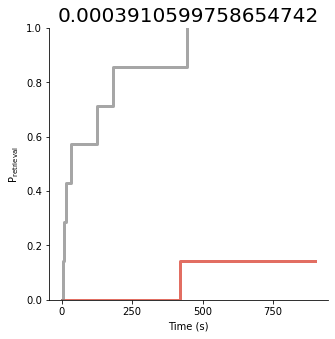

In [6]:
# Perform log-rank test on two selected DataFrames
km_results = pd.DataFrame()

for key1, df1 in day_dfs.items():
    for key2, df2 in day_dfs.items():
        if key1 != key2:
            result = logrank_test(df1['latency'], df2['latency'], 
                                  event_observed_A = df1['event'], event_observed_B=df2['event'])
            # Create a DataFrame for the new row and concatenate it with km_results
            new_row = pd.DataFrame({'day1': [key1], 'day2': [key2], 'p_value': [result.p_value]})
            km_results = pd.concat([km_results, new_row], ignore_index=True)

            if key1 == 'day0' and key2 == 'day4':
                # Plot the survival curves
                plt.subplots(figsize=(5,5))
                kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)
                kmfs['day4'].plot_cumulative_density(ci_show=False,label=key2,
                                                    linewidth=3,color='grey',legend=False, alpha=.7)

                plt.ylim(-0.1,1.1)
                params = {'mathtext.default': 'regular' }          
                plt.rcParams.update(params)
                plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
                plt.xlabel('Time (s)', labelpad=5)
                sns.despine()
                plt.title(str(result.p_value), fontsize=20)
                plt.locator_params(axis='x', nbins=4)
                plt.ylim(0,1)

# km_results.to_csv('/Users/salgari/Documents/Documents - XJK222YYCT/GitHub/sensitization_behaviour/generated_dataset/km_results_motor_skills.csv')

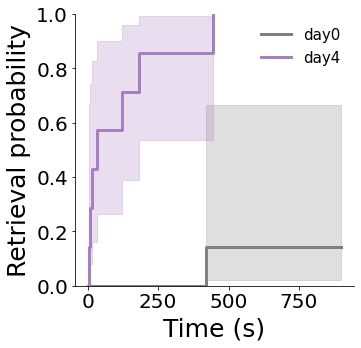

In [12]:
times = ['day0', 'day4']
col = ['grey', '#a87dc2']

fig, ax = plt.subplots(figsize=(5,5))  # Assigning an explicit axis

line_handles = []  # Store line handles for the legend
for i, time in enumerate(times):
    kmfs[time].plot_cumulative_density(ci_show=True, linewidth=3, legend=False, alpha=1, color=col[i], ax=ax)
    
    # Get the last plotted line and store it for the legend
    line_handles.append(ax.get_lines()[-1])

# Set labels, ticks, and limits
ax.set_ylim(-0.1, 1.1)
params = {'mathtext.default': 'regular'}
plt.rcParams.update(params)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Retrieval probability', multialignment='center', labelpad=5, fontsize=25)
plt.xlabel('Time (s)', labelpad=5, fontsize=25)

# Explicitly set the legend using the correct line handles
plt.legend(handles=line_handles, labels=times, loc='upper right', fontsize=15, frameon=False)

sns.despine()
plt.locator_params(axis='x', nbins=4)
plt.ylim(0, 1)

# Save the plot
plt.savefig('plots_motorskills/survival_motor_skills_retr_to_nest.png', bbox_inches='tight', dpi=500)

plt.show()